<a href="https://colab.research.google.com/github/amadousysada/scoring-model/blob/master/03_modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center; font-size:3.3em; color:#AD7D67; line-height:5rem; font-style:italic; font-weight:700;">
    Projet N°4 : <br>
    Implémentation d'un modèle de scoring </p>
<p style="text-align:center; font-size:2.8em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    IV - Modélisation
</p>

# 1. Préparation des données

In [2]:
# Forcer l'installation de la version 1.5.2 pour palier à une regression de scikit-learn qui impacte la librairie xgboost
# Line vers l'issue https://github.com/scikit-learn/scikit-learn/issues/30479

!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 106.0 MB/s eta 0:00:00


In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import warnings
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, auc, make_scorer, confusion_matrix, fbeta_score
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from yellowbrick.classifier import ConfusionMatrix

In [4]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve vos cvs.

In [5]:
X_train = pd.read_csv(f"{folder_path}final_cleaned_app_train.csv")
X_test = pd.read_csv(f"{folder_path}final_cleaned_app_test.csv")

In [6]:
X_train.drop(columns=['SK_ID_CURR'], inplace=True)
X_test.drop(columns=['SK_ID_CURR'], inplace=True)

In [7]:
X_train['TARGET'].isna().sum()

0

In [8]:
# Séparation de l'ensemble X_train en 2 sous-ensembles
y = X_train['TARGET']
X_train.drop(labels='TARGET', axis=1, inplace=True)

X_Xtrain, X_valid, y_train, y_valid = train_test_split(X_train, y, stratify=y, test_size=0.3, random_state=42)
X_Xtrain.shape, X_valid.shape

((215257, 15), (92254, 15))

TARGET
0    282686
1     24825
Name: count, dtype: int64


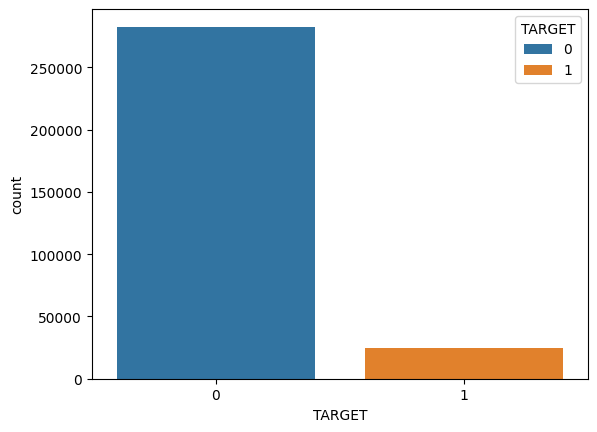

In [9]:
print(y.value_counts())
fig, ax = plt.subplots()
sns.countplot(data=y.to_frame(), x='TARGET', ax=ax, hue='TARGET')
xticks = ax.xaxis.get_ticks_position()
ax.xaxis.set_ticks([0, 1])
plt.show()

In [10]:
# Le ratio du desequilibre
print(f"imbalance_ratio = {24825 / 282686:.2%}")

imbalance_ratio = 8.78%


In [11]:
# Fonction pour calculer le coût métier
def business_cost(y_true, y_pred):
    """
    Calcule le coût métier en fonction des faux négatifs et faux positifs.

    Paramètres :
    y_true (array-like) : Les vraies étiquettes (0 ou 1).
    y_pred (array-like) : Les prédictions du modèle (0 ou 1).

    Retourne :
    float : Le coût métier basé sur 10 * FN + FP.
    """
    # Matrice de confusion : [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calcul du coût métier
    cost = 10 * fn + fp
    return cost

# Scorer pour le coût métier
business_scorer = make_scorer(business_cost, greater_is_better=False)

# 2. Dummy Classifier

Metric accuray: 0.9192663732737876
Metric roc_auc: 0.5
Metric f1: 0.0
Metric Metier: 74480
Matrice de confusion:
[[84806     0]
 [ 7448     0]]


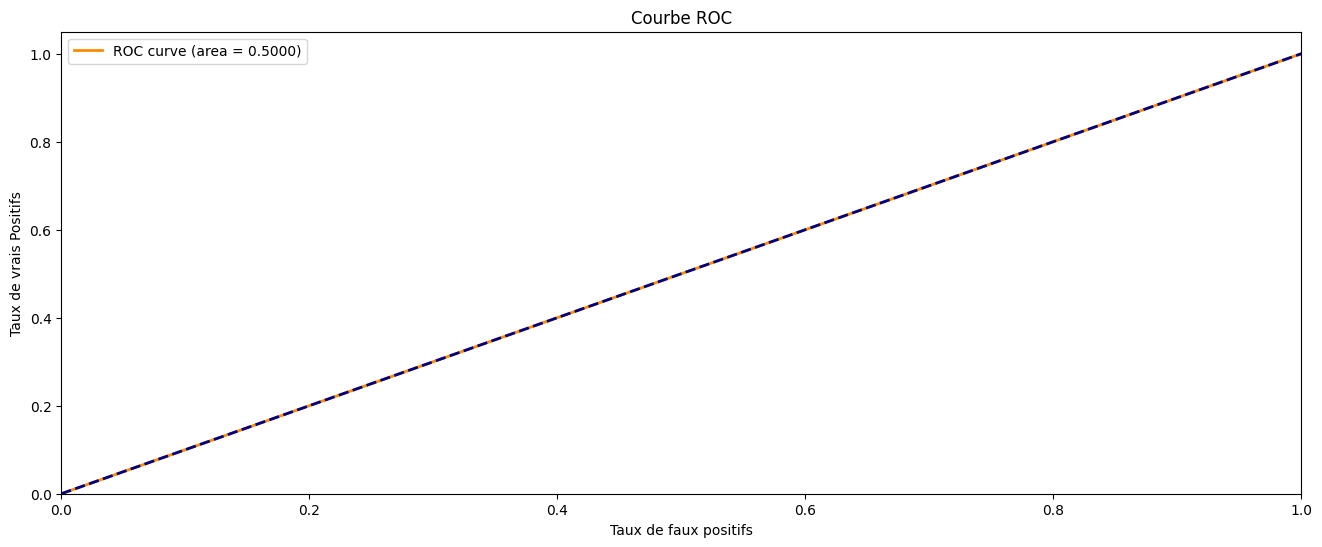

In [12]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

dummy_clf.fit(X_Xtrain, y_train)

# Prédictions
y_pred = dummy_clf.predict(X_valid)
y_prob = dummy_clf.predict_proba(X_valid)[:, 1]

# Calcul des métriques
accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_prob)
f1 = f1_score(y_valid, y_pred)

# Metric metier
cost = business_cost(y_valid, y_pred)

conf_matrix = confusion_matrix(y_valid, y_pred)

print(f"Metric accuray: {accuracy}")
print(f"Metric roc_auc: {roc_auc}")
print(f"Metric f1: {f1}")
print(f"Metric Metier: {cost}")

print(f"Matrice de confusion:\n{conf_matrix}")

fpr, tpr, _ = roc_curve(y_valid, y_prob)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(16, 6))

# Visualiser la courbe ROC AUC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="upper left")
plt.show()

In [80]:

models = {
    "Logistic Regression": LogisticRegression(random_state=42, n_jobs=-1),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
    "SVM": SVC(probability=True, kernel='linear', random_state=42, cache_size=700),
    "Naive Bayes": GaussianNB()
}

# Grilles d'hyperparamètres
param_grids = {
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["l2"],
        "model__class_weight": [None, "balanced"]
    },
    "Random Forest": {
        "model__n_estimators": [10, 100],
        "model__max_depth": [3, 6],
        "model__class_weight": [None, "balanced"]
    },
    "XGBoost": {
        "model__n_estimators": [10, 100],
        "model__learning_rate": [0.1, 0.2],
        "model__max_depth": [6, 10],
        "model__scale_pos_weight": [1, 5, 10]
    },
    "LightGBM": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.01, 0.1, 0.2, 0.3],
        "model__max_depth": [6, 10],
        "model__scale_pos_weight": [1, 5, 10]
    },
    "SVM": {
        "model__C": [0.1, 1, 10],
        "model__gamma": [1, 0.1, 0.01]
    }
}


In [14]:
# Résultats des modèles
model_results = {}
import os
if os.path.exists(f"{folder_path}grid_search_results.pkl"):
    with open(f"{folder_path}grid_search_results.pkl", "rb") as f:
        model_results = pickle.load(f)

In [15]:
model_results

{}

In [16]:
# Un decorateur pour tracker le temps d'execution des modéles
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Temps d'entrainement du modèle {kwargs.get('model_name')}: {execution_time:.2f} secondes")
        return result
    return wrapper

In [61]:
@timer
def evaluate_model(model_name, X_train, y_train, X_valid, y_valid, force=True):
  """
  Entrainer un modèle, prédire sur l'ensemble de validation et évaluer les performances.

  Paramètres :
  model_name : Le nom modèle à entraîner.
  X_train, y_train : Les données d'entraînement.
  X_valid, y_valid : Les données de validation.

  Retourne :
  obj: Les résultats de l'évaluation du modèle.
  """
  print(f"Évaluation du modèle : {model_name}")

  # Pipeline avec SMOTE
  pipeline = ImbPipeline(steps=[
      ("imputer", SimpleImputer(strategy="median")),
      ("scaler", StandardScaler()),
      ("smote", SMOTE(random_state=42)),  # SMOTE pour rééquilibrer les classes
      ("model", models[model_name])
  ])

  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  # GridSearchCV
  grid_search = GridSearchCV(
      estimator=pipeline,
      param_grid=param_grids[model_name],
      scoring={
          "business_score": business_scorer,
          "AUC": "roc_auc",
          "F1": "f1",
          "Accuracy": "accuracy",
          "Recall": "recall",
          "Precision": "precision",
          "F2": make_scorer(fbeta_score, beta=2)
      },
      refit="business_score",  # Optimisation basée sur le score métier
      cv=cv,
      verbose=1,
      return_train_score=True
  )

  # Entraînement
  if force or model_name not in model_results:
    grid_search.fit(X_train, y_train)
    model_results[model_name] = grid_search
  else:
    grid_search = model_results[model_name]

  # Sauvegarder les resultats, pour eviter plus tard le coùt de calcul
  with open(f"{folder_path}grid_search_results.pkl", "wb") as f:
    pickle.dump(grid_search, f)

  y_pred = grid_search.predict(X_valid)
  y_prob = grid_search.predict_proba(X_valid)[:, 1]

  # Résultats
  print("Meilleurs paramètres :", grid_search.best_params_)
  print("Meilleur score métier :", grid_search.best_score_)
  print("Matrice de confusion :", confusion_matrix(y_valid, y_pred))

  fpr, tpr, _ = roc_curve(y_valid, y_prob)
  roc_auc = auc(fpr, tpr)

  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))

  # Récupérer les scores pour chaque combinaison d'hyperparamètres
  scores = -grid_search.cv_results_['mean_test_business_score']
  params = grid_search.cv_results_['params']

  # Visualiser notre score metier
  ax0.plot(range(len(scores)), scores, marker='o')
  ax0.set_title("Score métier pour chaque combinaison d'hyperparamètres")
  ax0.set_xlabel("Index de la combinaison d'hyperparamètres")
  ax0.set_ylabel("Score métier (plus bas est meilleur)")
  ax0.set_xticks(range(len(scores)), labels=[str(p) for p in params], rotation=90)
  ax0.grid(True)

  # Visualiser la courbe ROC AUC
  ax1.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
  ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  ax1.set_xlim([0.0, 1.0])
  ax1.set_ylim([0.0, 1.05])
  ax1.set_xlabel('Taux de faux positifs')
  ax1.set_ylabel('Taux de vrais Positifs')
  ax1.set_title('Courbe ROC')
  ax1.legend(loc="upper left")

  plt.show()

  print("-" * 50)
  return grid_search

In [69]:
def visualize_confusion_matrix(model, X_valid, y_valid, classes=['non_defaut_payment', 'defaut_payment']):
  sns.set_style("ticks")
  fig, ax = plt.subplots(figsize=(6, 4))
  cm = ConfusionMatrix(model, classes=classes)
  cm.fit(X_train, y_train)
  cm.score(X_valid, y_valid)
  cm.show()

# 3. RandomForest

Évaluation du modèle : Random Forest
Meilleurs paramètres : {'model__class_weight': None, 'model__max_depth': 6, 'model__n_estimators': 100}
Meilleur score métier : -26326.2
Matrice de confusion : [[57020 27786]
 [ 2816  4632]]


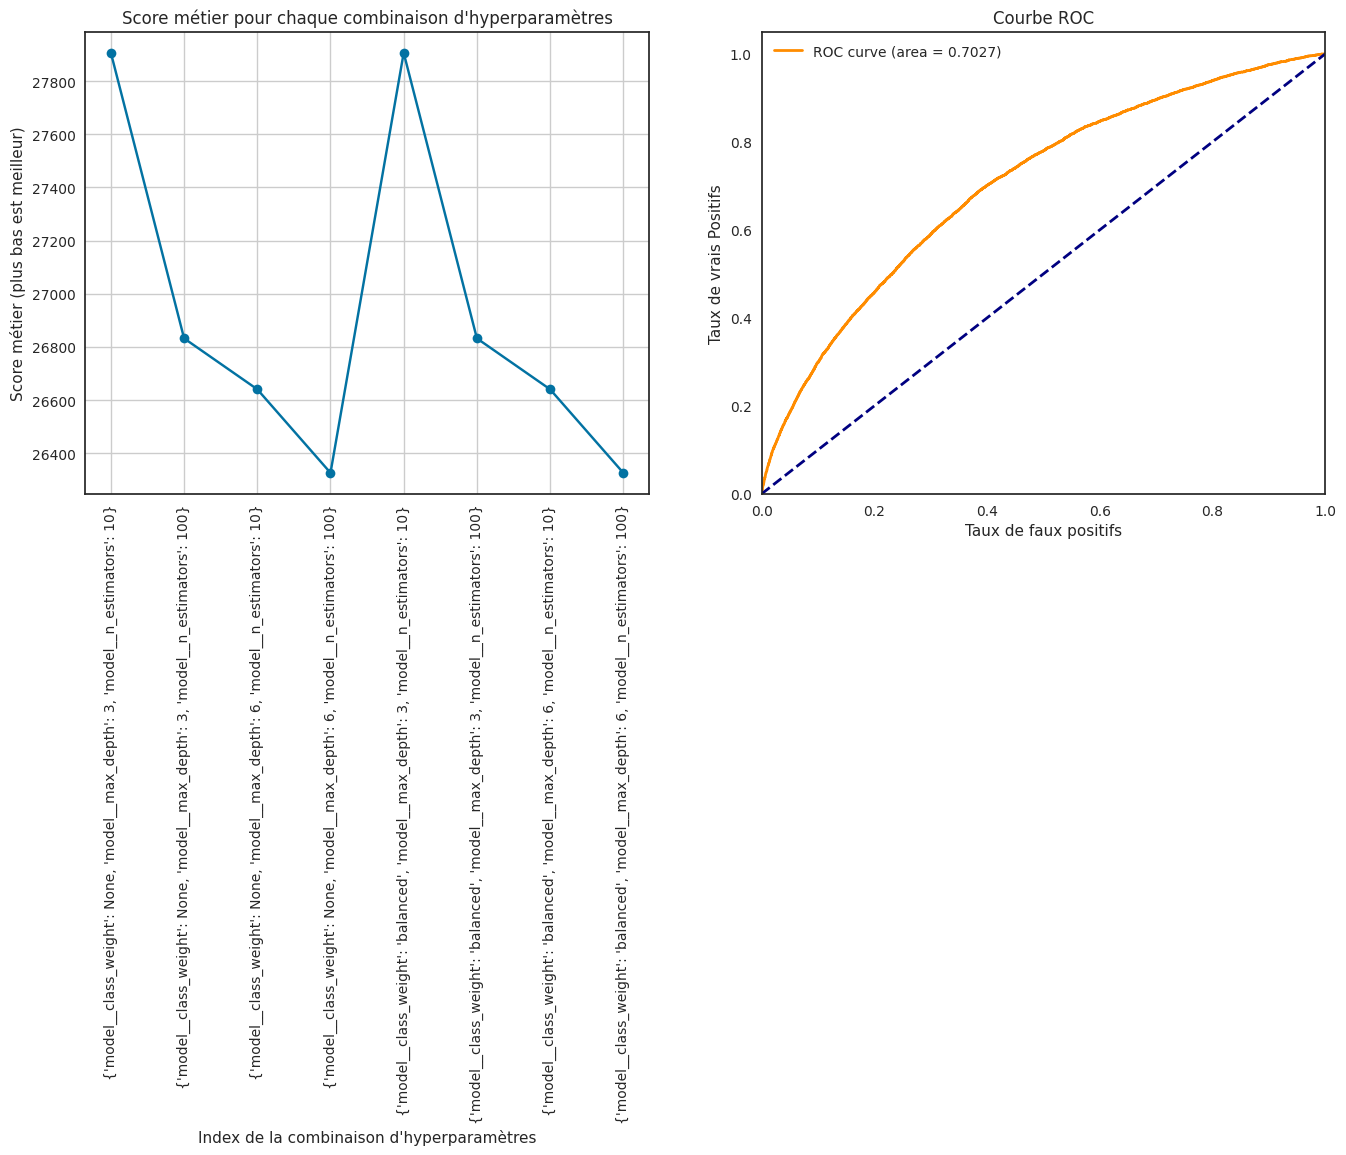

--------------------------------------------------
Temps d'entrainement du modèle Random Forest: 0.68 secondes


In [63]:
res = evaluate_model(model_name='Random Forest', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

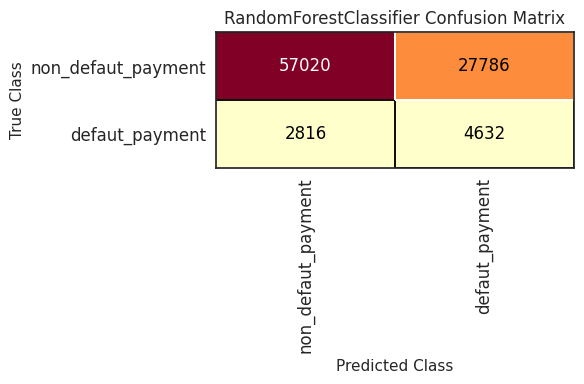

In [70]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

Le modèle a correctement identifié **57 020** cas comme négatifs (TN) et **4 632** cas comme positifs (TP). Cependant, il a également commis des erreurs en identifiant **27 786** cas négatifs comme positifs (FP) et en manquant **2 816 **cas positifs en les identifiant comme négatifs (FN).

# 4. Logistic Regression

Évaluation du modèle : Logistic Regression
Meilleurs paramètres : {'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l2'}
Meilleur score métier : -24676.0
Matrice de confusion : [[57940 26866]
 [ 2555  4893]]


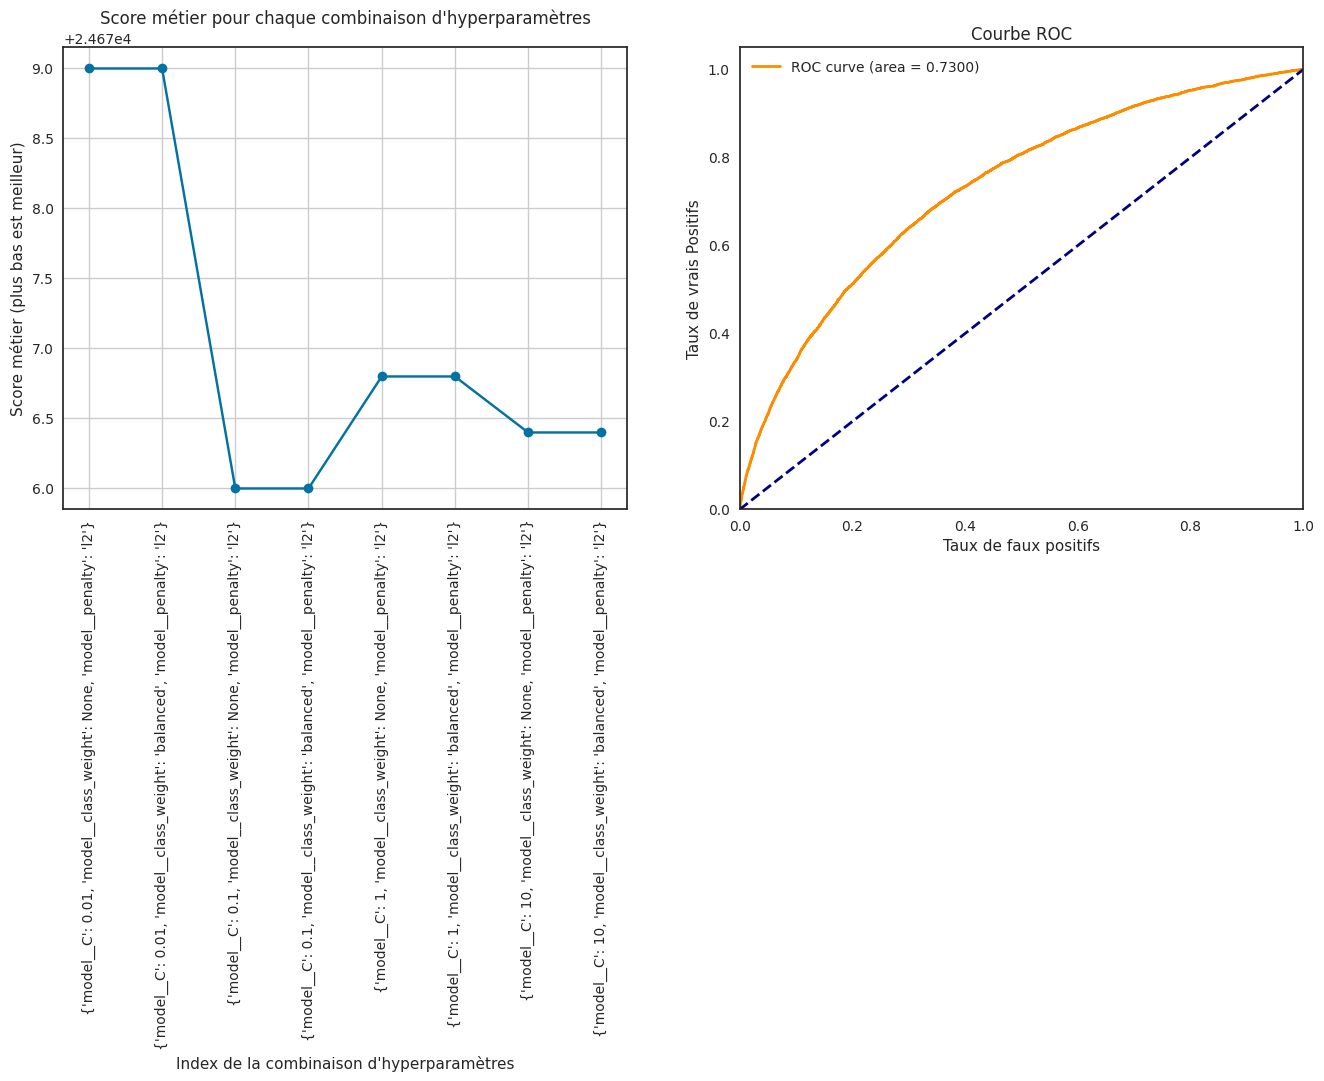

--------------------------------------------------
Temps d'entrainement du modèle Logistic Regression: 0.57 secondes


In [73]:
res = evaluate_model(model_name='Logistic Regression', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

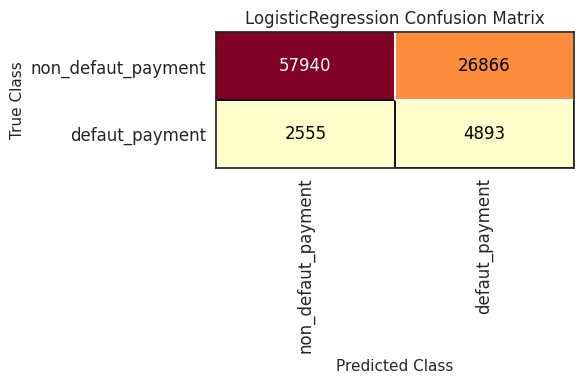

In [74]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

- Le modèle de Régression Logistique a correctement identifié 57 940 cas comme négatifs (TN) et 4 893 cas comme positifs (TP).

- Cependant, il a également commis des erreurs en identifiant 26 866 cas négatifs comme positifs (FP) et en manquant 2 555 cas positifs en les identifiant comme négatifs (FN).

# 5. LightGBM

Évaluation du modèle : LightGBM
Meilleurs paramètres : {'model__learning_rate': 0.01, 'model__max_depth': 10, 'model__n_estimators': 200, 'model__scale_pos_weight': 1}
Meilleur score métier : -26024.4
Matrice de confusion : [[65013 19793]
 [ 3560  3888]]


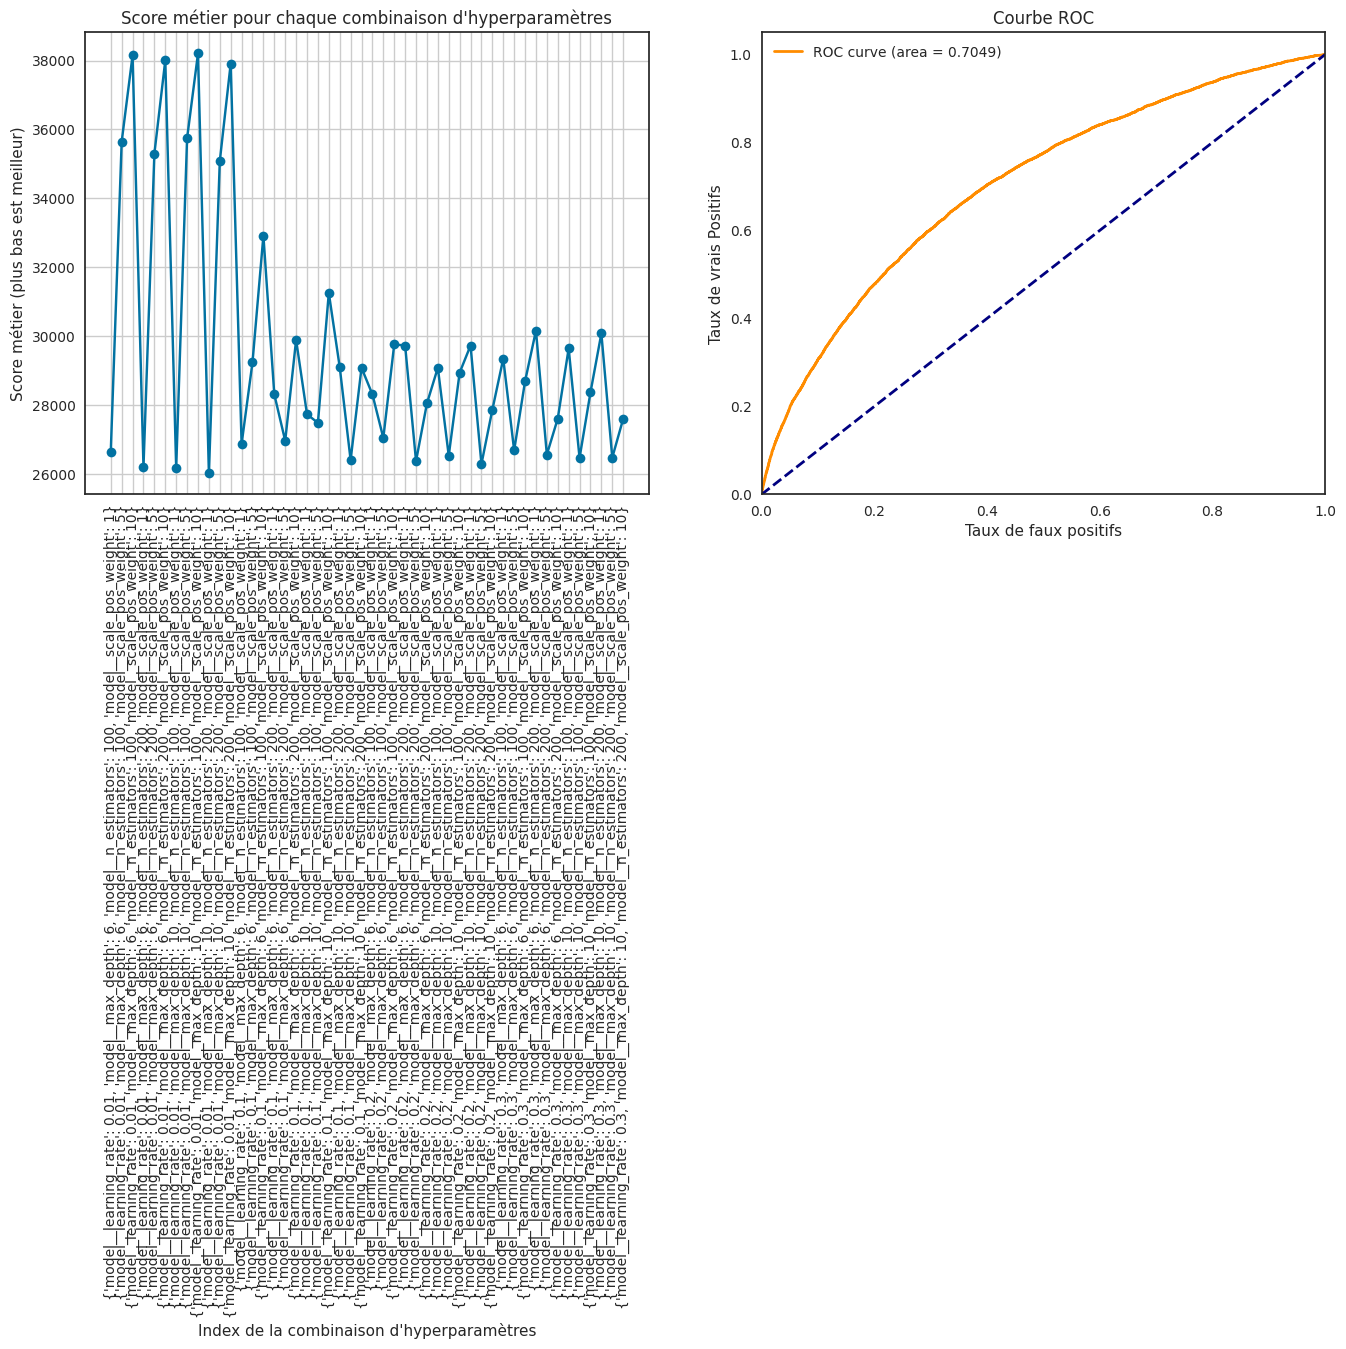

--------------------------------------------------
Temps d'entrainement du modèle LightGBM: 1.23 secondes


In [75]:
warnings.simplefilter("ignore", FutureWarning)
res = evaluate_model(model_name='LightGBM', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

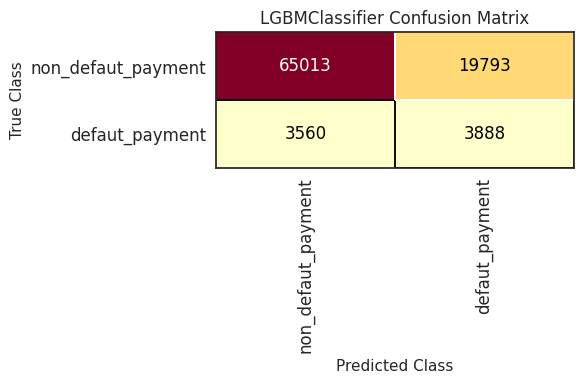

In [77]:
visualize_confusion_matrix(res.best_estimator_, X_valid, y_valid)

- Le modèle LightGBM a correctement identifié 65 013 cas comme négatifs (TN) et 3 888 cas comme positifs (TP).
- Cependant, il a également commis des erreurs en identifiant 19 793 cas négatifs comme positifs (FP) et en manquant 3 560 cas positifs en les identifiant comme négatifs (FN).


# 6. XGBoost

Évaluation du modèle : XGBoost
Meilleurs paramètres : {'model__learning_rate': 0.2, 'model__max_depth': 6, 'model__n_estimators': 10, 'model__scale_pos_weight': 1}
Meilleur score métier : -26179.0
Matrice de confusion : [[60939 23867]
 [ 3210  4238]]


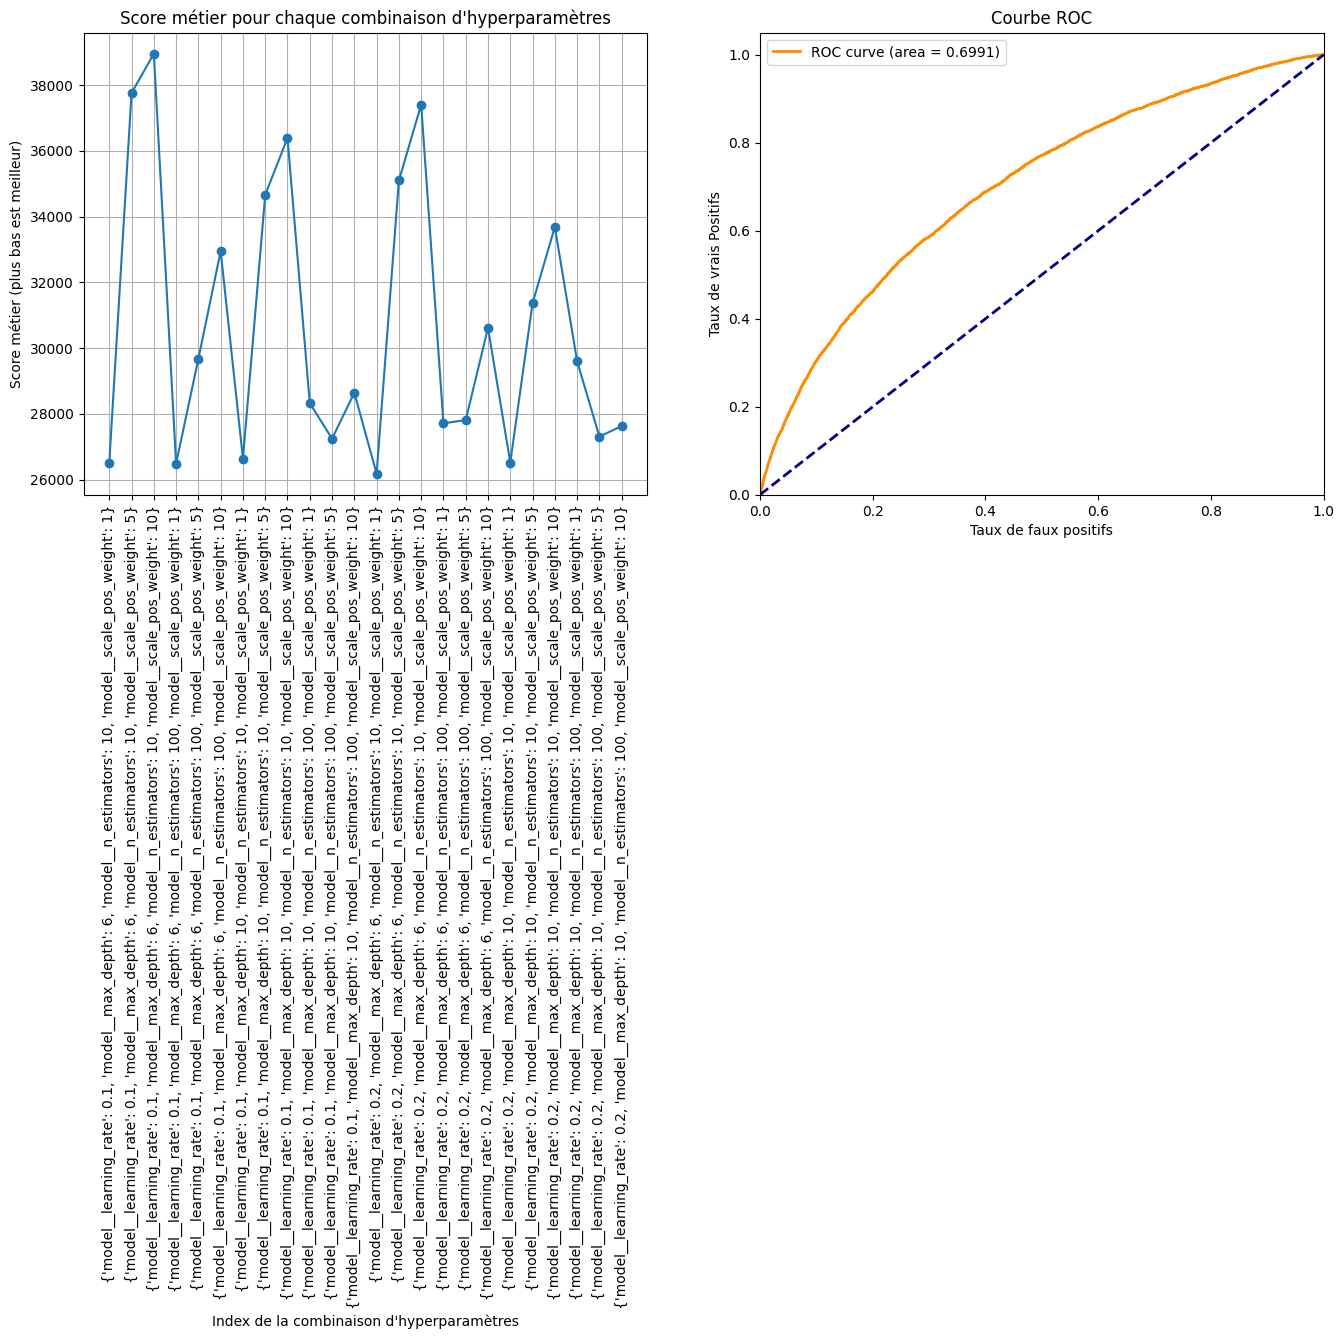

--------------------------------------------------
Temps d'entrainement du modèle XGBoost: 0.73 secondes


In [36]:
warnings.simplefilter("ignore", UserWarning)
res = evaluate_model(model_name='XGBoost', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

# 7. SVM

In [ ]:
res = evaluate_model(model_name='SVM', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

Évaluation du modèle : SVM
Fitting 5 folds for each of 9 candidates, totalling 45 fits


# 8. Naive Baise

In [ ]:
res = evaluate_model(model_name='Naive Bayes', X_train=X_Xtrain, y_train=y_train, X_valid=X_valid, y_valid=y_valid, force=False)

# 9. Comparaison des modéles

In [50]:
metrics = [
    'business_score',
    'AUC',
    'F1',
    'Accuracy',
    'Recall',
    'Precision',
    'F2'
]

cv_results = {}
for key, grid_search in model_results.items():
    results = grid_search.cv_results_
    t = {}
    for metric in metrics:
      score = f"{results[f'mean_test_{metric}'][grid_search.best_index_]:.4f}"
      t[metric] = score
    cv_results[key] = t

metrics_df = pd.DataFrame(cv_results)
metrics_df.T

,business_score,AUC,F1,Accuracy,Recall,Precision,F2
Random Forest,-26326.2000,0.6978,0.2308,0.6714,0.6106,0.1423,0.3682
Logistic Regression,-24676.0000,0.7259,0.2473,0.6794,0.6524,0.1526,0.3941
LightGBM,-26024.4000,0.7055,0.2471,0.7441,0.5202,0.1620,0.3607
XGBoost,-26179.0000,0.6996,0.2377,0.7062,0.5675,0.1504,0.3650
